<a href="https://colab.research.google.com/github/Erzikovskij/Azsii/blob/main/PRZ_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from typing import Any
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
# Загрузка тестовых данных MNIST
(_, _), (test_images, test_labels) = mnist.load_data()
# Нормализация данных
test_images = test_images / 255.0
test_labels = to_categorical(test_labels, num_classes=10)
# Загрузка обученной модели
model = tf.keras.models.load_model('mnist_model.h5')
# Проверка точности модели на обычных данных
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9717 - loss: 0.1022
Test accuracy on clean images: 0.9750999808311462


In [10]:
!pip install foolbox

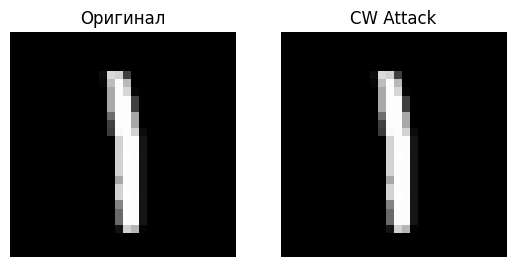

In [11]:
import foolbox as fb
import numpy as np

# Инициализация Foolbox модели
fmodel = fb.TensorFlowModel(model, bounds=(0, 1))

# Конвертация и выборка
image = tf.convert_to_tensor(test_images[37], dtype=tf.float32)[None, ...]
label = np.argmax(test_labels[0]) # Получаем индекс класса
label = tf.convert_to_tensor(label, dtype=tf.int64) # Конвертируем в тензор

# Создание и выполнение Carlini-Wagner атаки
attack = fb.attacks.L2CarliniWagnerAttack(steps = 100)
adversarial_image = attack(fmodel, image, label[None], epsilons=0.1)

# Вывод результатов
import matplotlib.pyplot as plt
plt.subplot(1, 2, 1)
plt.title("Оригинал")
plt.imshow(image[0].numpy(), cmap="gray")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("CW Attack")
plt.imshow(adversarial_image[0][0].numpy(), cmap="gray")
plt.axis('off')
plt.show()

In [12]:
# Создание набора противоречивых примеров для всего тестового набора
adversarial_images = []
batch_size = 10

# Обработка изображений пакетами
for i in range(0, len(test_images) // 10, batch_size):

    # Создаем пакет изображений и меток
    batch_images = tf.convert_to_tensor(test_images[i:i + batch_size], dtype=tf.float32)
    batch_labels = np.argmax(test_labels[i:i + batch_size], axis=1)
    batch_labels = tf.convert_to_tensor(batch_labels, dtype=tf.int64)

    # Проверка размерности
    advs, _, success = attack(fmodel, batch_images, batch_labels, epsilons=0.1)
    adversarial_images.append(advs)

# Конвертация списка в массив с правильной формой
adversarial_images = tf.concat(adversarial_images, axis=0)

# Оценка точности модели на противоречивых примерах
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels[:len(adversarial_images)])
print(f'Accuracy on adversarial examples (CW attack): {adversarial_acc}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0286 - loss: 1.2550
Accuracy on adversarial examples (CW attack): 0.02800000086426735


In [13]:
print(f'Test accuracy on clean images: {test_acc:}')
print(f'Accuracy on adversarial examples (CW attack): {adversarial_acc:}')

Test accuracy on clean images: 0.9750999808311462
Accuracy on adversarial examples (CW attack): 0.02800000086426735
